### SMA Lab 7: Link Prediction of future connections in Facebook

###### Step-1:

In [1]:
!pip install --upgrade networkx

  Attempting uninstall: networkx
    Found existing installation: networkx 2.5.1
    Uninstalling networkx-2.5.1:
      Successfully uninstalled networkx-2.5.1


In [2]:
!pip install lightgbm

In [3]:
!pip install node2vec

  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import lightgbm as lgbm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

###### Step-2:

In [6]:
with open("fb-pages-food.nodes", "r+", encoding="utf-8") as f:
    fb_nodes = f.read().splitlines()
len(fb_nodes)

621

In [7]:
with open("fb-pages-food.edges", "r+", encoding="utf-8") as f:
    fb_links = f.read().splitlines()
len(fb_links)

2102

In [8]:
node_list_1 = []
node_list_2 = []
for i in tqdm(fb_links):
    node_list_1.append(i.split(',')[0])
    node_list_2.append(i.split(',')[1])
fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 560378.00it/s]


In [9]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


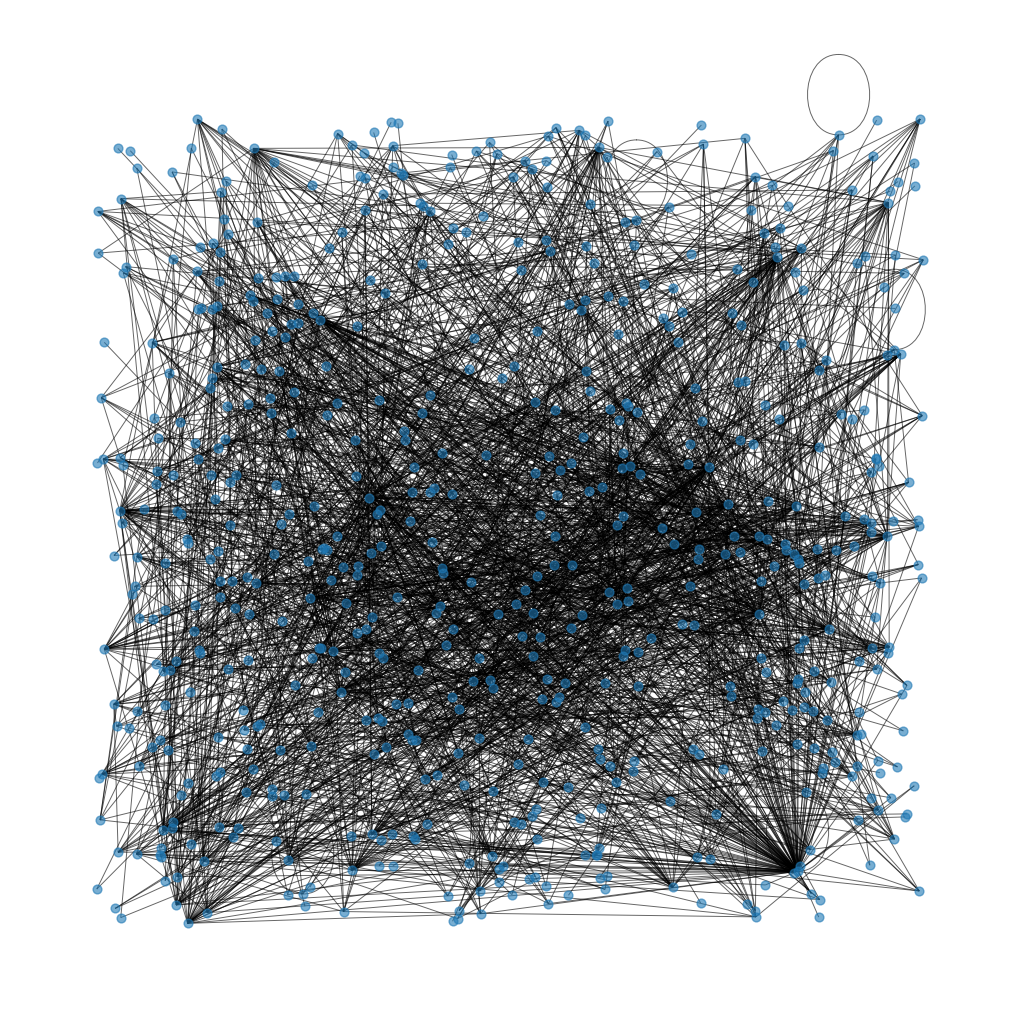

In [10]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())
plt.figure(figsize=(10,10))
pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)
plt.show()

###### Step-3:

In [11]:
node_list = node_list_1 + node_list_2
node_list = list(dict.fromkeys(node_list))
adj_G = nx.adjacency_matrix(G, nodelist=node_list)

In [12]:
adj_G.shape

(620, 620)

In [13]:
all_unconnected_pairs = []
offset = 0
for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
        if i != j:
            if nx.shortest_path_length(G, str(i), str(j)) <=2:
                if adj_G[i,j] == 0:
                    all_unconnected_pairs.append([node_list[i],node_list[j]])
    offset = offset + 1

100%|██████████| 620/620 [00:16<00:00, 37.46it/s] 


In [14]:
len(all_unconnected_pairs)

19018

In [15]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]
data = pd.DataFrame({'node_1':node_1_unlinked,'node_2':node_2_unlinked})
data['link'] = 0

In [16]:
initial_node_count = len(G.nodes)
fb_df_temp = fb_df.copy()
omissible_links_index = []
for i in tqdm(fb_df.index.values):
    G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
    if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        omissible_links_index.append(i)
        fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:21<00:00, 97.81it/s] 


In [17]:
len(omissible_links_index)

1483

In [18]:
fb_df_ghost = fb_df.loc[omissible_links_index]
fb_df_ghost['link'] = 1
data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [19]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

###### Step-4:

In [20]:
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

###### Step-5:

In [21]:
from node2vec import Node2Vec
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:02<00:00, 23.70it/s]


In [22]:
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [23]:
xtrain,xtest,ytrain,ytest=train_test_split(np.array(x),data['link'],test_size=0.3,random_state=35)

In [24]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')


In [25]:
predictions = lr.predict_proba(xtest)

In [26]:
roc_auc_score(ytest, predictions[:,1])

0.8072017510042158

In [27]:
!pip install --upgrade lightgbm


In [28]:
train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)
parameters = {'objective': 'binary','metric': 'auc','is_unbalance': 'true','feature_fraction': 0.5,'bagging_fraction': 0.5,'bagging_freq': 20,'num_threads' : 2,'seed' : 76}
model = lgbm.train(parameters, train_data, valid_sets=[test_data], num_boost_round=1000)


[LightGBM] [Info] Number of positive: 1062, number of negative: 13288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14350, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074007 -> initscore=-2.526707
[LightGBM] [Info] Start training from score -2.526707


In [29]:
y_pred = model.predict(xtest)
roc_auc = roc_auc_score(ytest, y_pred)
print("ROC AUC:", roc_auc)

ROC AUC: 0.9430326696596237
